## 13. アンサンブル学習
**アンサンブル法**は、さまざまな分類器を1つのメタ分類器として組み合わせる手法である。  
最もよく知られているアンサンブル法は、多数決の原理を利用するものである。  
多数決が表すのは二値分類問題だけであり、多クラス分類に一般化したものは**相対多数決**と呼ばれる。  
この場合は、最も得票の多いクラスラベルが選択される。  
  
まず、$m$種類の分類器($C_1,\cdots,C_m$)の訓練を行う。  
決定木やSVMなどさまざまな分類アルゴリズムを使用できる。  
さまざまな決定木を組み合わせたものがランダムフォレストである。  
多数決に基づいてクラスラベルを予測するには、個々の分類器$C_j$で予測されたクラスラベルをまとめ、最も得票の多いクラスラベルを選択する。
$$
\hat{y}=mode\bigl\{C_1(x),C_2(x),\cdots,C_m(x) \bigr\}
$$

$n$個のベース分類器の誤分類率が等しく$\epsilon$であるとする。  
このときベース分類器のアンサンブルの誤分類率を二項分布の確率質量関数として表すことができる。
$$
P(y\geq k)=\sum_k^n
\begin{pmatrix}
n\\
k
\end{pmatrix}
\epsilon^k (1-\epsilon)^{(n-k)}
$$ 

通常アンサンブル学習の誤分類率は、個々の分類器の誤分類率よりも低くなる。   
  
scikit-learnのVotingClassifierには、  
予測結果の多数決を行うHard Votingと、分類確率の平均値をとるSoft Votingがある。

In [32]:
from sklearn import datasets

iris = datasets.load_iris()
Xcl = iris.data
ycl = iris.target

In [10]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cuan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8,
                    label=cl, 
                    cmap=cmap,
                    edgecolor='black')

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import VotingClassifier

estimators = [
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(n_estimators=10)),
    ('logit', LogisticRegression(max_iter=200)),
    ('knn', KNeighborsClassifier()),
    ('nb', GaussianNB()),
]


vc_hard = VotingClassifier(estimators, voting='hard')
vc_hard.fit(Xcl[:,[2,3]], ycl)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(n_estimators=10)),
                             ('logit', LogisticRegression(max_iter=200)),
                             ('knn', KNeighborsClassifier()),
                             ('nb', GaussianNB())])

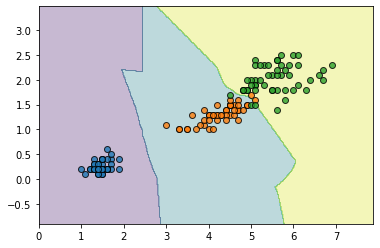

In [34]:
plot_decision_regions(Xcl[:,[2,3]], ycl, vc_hard)

回帰問題におけるアンサンブル学習は、  
各回帰モデルの予測値の平均値をとったものを予測値とする。

In [35]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()
Xreg = pd.DataFrame(boston.data, columns=boston.feature_names)
Xreg = Xreg[['LSTAT']].values
yreg = boston.target

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import VotingRegressor

estimators = [
    ('GBR', GradientBoostingRegressor(random_state=1, n_estimators=10)),
    ('rf', RandomForestRegressor(random_state=1, n_estimators=10)),
    ('lr', LinearRegression(normalize=True))
]

VRreg = VotingRegressor(estimators=estimators)
VRreg.fit(Xreg, yreg)

VotingRegressor(estimators=[('GBR',
                             GradientBoostingRegressor(n_estimators=10,
                                                       random_state=1)),
                            ('rf',
                             RandomForestRegressor(n_estimators=10,
                                                   random_state=1)),
                            ('lr', LinearRegression(normalize=True))])

In [24]:
def lin_reg_plot(X, y, model, c):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color=c ,lw=2)
    return

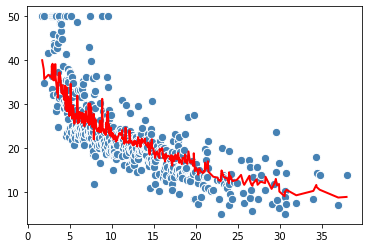

In [37]:
sort_idx = X.flatten().argsort()

lin_reg_plot(Xreg[sort_idx], yreg[sort_idx], VRreg, 'red')

#### バギング
ブートストラップ集約とも呼ばれ、アンサンブル学習の1つである。  
ただし、個々の分類器の学習に同じ訓練データセットを使うのではなく、  
最初の訓練データセットからブートストラップ標本を抽出する(ランダムな復元抽出)。

In [38]:
from sklearn.ensemble import BaggingClassifier

svc = SVC(probability=True)
bag = BaggingClassifier(base_estimator=svc,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=-1)

bag.fit(Xcl[:,[2,3]], ycl)

BaggingClassifier(base_estimator=SVC(probability=True), n_estimators=500,
                  n_jobs=-1)

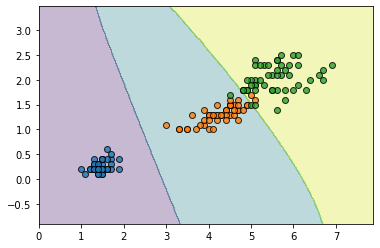

In [39]:
plot_decision_regions(Xcl[:,[2,3]], ycl, bag)

回帰も同様に実装できる

In [48]:
from sklearn.ensemble import BaggingRegressor

rf = RandomForestRegressor(random_state=1, n_estimators=20)
bag = BaggingRegressor(base_estimator=rf,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=-1)

bag.fit(Xreg, yreg)

BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=20,
                                                      random_state=1),
                 n_estimators=500, n_jobs=-1)

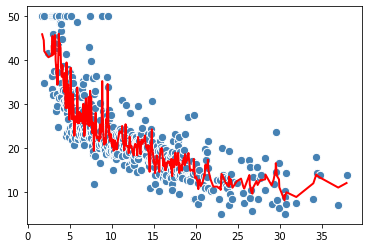

In [49]:
sort_idx = X.flatten().argsort()

lin_reg_plot(Xreg[sort_idx], yreg[sort_idx], bag, 'red')

#### ブースティング
分類の難しい訓練データに焦点を合わせ、誤分類された訓練データをあとから弱学習機に学習させることで、アンサンブルの性能を向上させる。  
一般的なブースティングの手順を示す。
1. 訓練データセット$D$から訓練データのランダムなサブセット$d_1$を非復元抽出し、弱学習機$C_1$を訓練する
2. 2つ目のランダムな訓練サブセット$d_2$を訓練データセットから非復元抽出し、  
以前に誤分類されたデータ点の50%を追加して、弱学習機$C_2$を訓練する  
3. 訓練データセット$D$から$C_1$と$C_2$の結果が異なる訓練データ$d_3$を洗い出し、3つ目の弱学習機$C_3$を訓練する
4. 弱学習機$C_1$、$C_2$、$C_3$を多数決により組み合わせる  
  
ここでは、よく知られているブースティングアルゴリズムの**アダブースト**の手順を見ていく。  
1. 訓練データの重みベクトル$\boldsymbol{w}$を設定し、次の条件が満たされるようにすべてのデータ点の重みを等しく設定する  
（重みベクトルの成分$w_i$は$i$番目のデータ点の重みを表し、データ点が$N$個ある場合は$w_i=1/N$となる） 
$$
\sum_iw_i=1
$$

2. 全体で$m$回実行するブースティングのうち、$j$回目のステップで手順a～fを繰り返す  
　a. 重み付けされた弱学習機$C_j$を訓練する  
$$
C_j=train(\boldsymbol{X},\boldsymbol{y},\boldsymbol{w})
$$
　b. クラスラベル$\hat{\boldsymbol{y}}$を予測する  
$$
\hat{\boldsymbol{y}}=predict(C_j,\boldsymbol{X})
$$
　c. 重み付けされた誤分類率$\epsilon$を計算する
$$
\epsilon=\boldsymbol{w}・(\hat{\boldsymbol{y}}\neq \boldsymbol{y})
$$
　d. 重みの更新に用いる係数$\alpha_j$を計算する
$$
\alpha_j=0.5\log{\frac{1-\epsilon}{\epsilon}}
$$
　e. 重みを更新
$$
\boldsymbol{w} = \boldsymbol{w}×\exp{(-\alpha×\hat{\boldsymbol{y}}×\boldsymbol{y})}
$$
　f. 重みを正規化して合計が1になるようにする
$$
\boldsymbol{w}=\frac{\boldsymbol{w}}{\sum_iw_i}
$$
3. 入力された特徴量行列$\boldsymbol{X}$に対する最終予測$\hat{\boldsymbol{y}}$を計算する  
各手順で推定した重み$\alpha_j$で予測結果を重み付けた平均が0よりも大きければ1, 平均が0以下ならば-1とする  
$$
\hat{\boldsymbol{y}}=\biggl(\sum_{j=1}^m(\alpha_j×predict(C_j,\boldsymbol{X}))>0 \biggr)
$$

In [53]:
from sklearn.ensemble import AdaBoostClassifier

svc = SVC(probability=True)
ada = AdaBoostClassifier(base_estimator=svc,
                         n_estimators=100,
                         learning_rate=0.1)

ada.fit(Xcl[:,[2,3]], ycl)

AdaBoostClassifier(base_estimator=SVC(probability=True), learning_rate=0.1,
                   n_estimators=100)

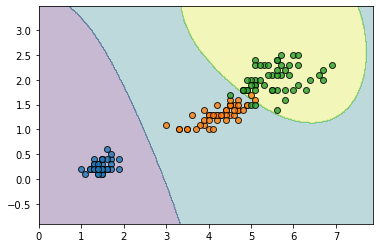

In [54]:
plot_decision_regions(Xcl[:,[2,3]], ycl, ada)

In [62]:
from sklearn.ensemble import AdaBoostRegressor

rf = RandomForestRegressor(random_state=1, n_estimators=20, max_depth=5)
ada = AdaBoostRegressor(base_estimator=rf,
                        n_estimators=500,
                        learning_rate=0.1)

ada.fit(Xreg, yreg)

AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=5,
                                                       n_estimators=20,
                                                       random_state=1),
                  learning_rate=0.1, n_estimators=500)

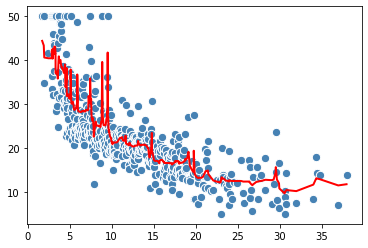

In [63]:
sort_idx = X.flatten().argsort()

lin_reg_plot(Xreg[sort_idx], yreg[sort_idx], ada, 'red')

#### スタッキング
2層の構造を持った手法であり、1層目で複数の予測器を使い予測値を出力し、  
2層目のモデルで各予測値を特徴量として学習を行う。

In [65]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(n_estimators=10)),
    ('logit', LogisticRegression(max_iter=200)),
    ('knn', KNeighborsClassifier()),
    ('nb', GaussianNB()),
]

SC = StackingClassifier(estimators, final_estimator=LogisticRegression())
SC.fit(Xcl[:,[2,3]], ycl)

StackingClassifier(estimators=[('svm', SVC(probability=True)),
                               ('rf', RandomForestClassifier(n_estimators=10)),
                               ('logit', LogisticRegression(max_iter=200)),
                               ('knn', KNeighborsClassifier()),
                               ('nb', GaussianNB())],
                   final_estimator=LogisticRegression())

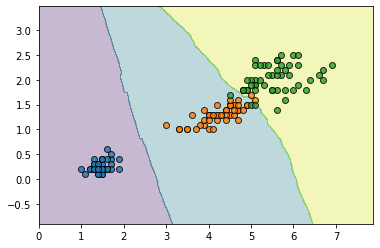

In [66]:
plot_decision_regions(Xcl[:,[2,3]], ycl, SC)

In [71]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('GBR', GradientBoostingRegressor(random_state=1, n_estimators=10)),
    ('rf', RandomForestRegressor(random_state=1, n_estimators=10)),
    ('lr', LinearRegression(normalize=True))
]

SR = StackingRegressor(estimators, final_estimator=RandomForestRegressor(max_depth=5))
SR.fit(Xreg, yreg)

StackingRegressor(estimators=[('GBR',
                               GradientBoostingRegressor(n_estimators=10,
                                                         random_state=1)),
                              ('rf',
                               RandomForestRegressor(n_estimators=10,
                                                     random_state=1)),
                              ('lr', LinearRegression(normalize=True))],
                  final_estimator=RandomForestRegressor(max_depth=5))

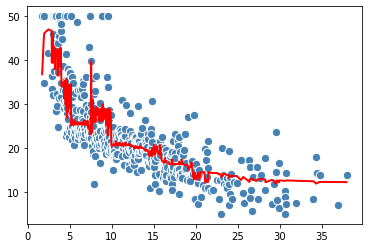

In [72]:
sort_idx = X.flatten().argsort()

lin_reg_plot(Xreg[sort_idx], yreg[sort_idx], SR, 'red')